# Working on your PhD thesis for 10 years is a long time and one wonders if there is not better way to spend the resources going into it. 
# In this Jupyter Notebook we would like to analyze what would have happened if we instead put our tuition money into bitcoint for that period of time

In [1]:
import pandas as pd
from datetime import datetime, timedelta, timezone

## First we access historical bitoin data from the following kaggle data set https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data and store it as file path

In [2]:
# Specify the file path and chunk size
file_path = 'archive/btcusd_1-min_data.csv'  # Corrected file path

## We now access data about the tuition money in the University of Hamburg. We are interested in the period from winter semester 2014 up to winter semester 2024. The available data only dates back to summer semester 2019 found here https://www.uni-hamburg.de/campuscenter/studienorganisation/studienverlauf/beitraege-gebuehren/semesterbeitrag.html . We simply assume that before that time, the tuition has been increased by 3 Euro every 2 years which seems to be the case in the last period we have data for.

In [3]:
# Tuition data for each semester
tuition = {
    "2014-09-30": 319.0,
    "2015-03-30": 322.0,
    "2015-09-30": 322.0,
    "2016-03-30": 322.0,
    "2016-09-30": 322.0,
    "2017-03-30": 325.0,
    "2017-09-30": 325.0,
    "2018-03-30": 325.0,
    "2018-09-30": 325.0,
    "2019-03-30": 328.0,
    "2019-09-30": 328.0,
    "2020-03-30": 328.0,
    "2020-09-30": 328.0,
    "2021-03-30": 332.0,
    "2021-09-30": 335.0,
    "2022-03-30": 335.0,
    "2022-09-30": 337.5,
    "2023-03-30": 339.9,
    "2023-09-30": 340.0,
    "2024-03-30": 332.0,
    "2024-09-30": 335.0
}

## We now assume that we pay our tuition always on the last possible day, which would be 30th of March and 30th of September for a given year. We always would pay at 10 am.

In [23]:
target_times = [
    {"month": 9, "day": 30, "hour": 10, "minute": 0},  # 30th September 10:00 am
    {"month": 3, "day": 30, "hour": 10, "minute": 0},  # 30th March 10:00 am
]


## Now we parse the initial bitcoin data set in 1e5 row chunks and generate a new data set containing bitcoin prices at the time of the tuition payments (we always take the "Low" value for a given minute). If the data is not available for 10 am we will take the closest time stamp to the desired time.

In [4]:
# Define a function to find the closest row to a target time
def find_closest_row(chunk, target_datetime):
    # Work on a copy to avoid modifying the original slice
    chunk = chunk.copy()
    chunk["Time_Difference"] = abs(chunk["Datetime"] - target_datetime)
    return chunk.loc[chunk["Time_Difference"].idxmin()]

In [7]:
# Initialize an empty list to store results
filtered_data = []
chunk_size = 100000

# Process the data in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Drop rows where Timestamp is NaN
    chunk = chunk.dropna(subset=["Timestamp"])

    # Convert Timestamp to a datetime object
    chunk["Datetime"] = pd.to_datetime(chunk["Timestamp"], unit="s", utc=True, errors="coerce")

    # Filter rows after 30-09-2014
    chunk = chunk.loc[chunk["Datetime"] >= datetime(2014, 9, 30, 0, 0, 0, tzinfo=timezone.utc)]

    # Loop through each target time
    for target in target_times:
        # Construct the target datetime for each year in the chunk
        unique_years = chunk["Datetime"].dt.year.unique()
        for year in unique_years:
            target_datetime = datetime(
                year=year,
                month=target["month"],
                day=target["day"],
                hour=target["hour"],
                minute=target["minute"],
                tzinfo=timezone.utc
            )
            # Find rows close to the target date
            rows_close_to_target = chunk.loc[
                (chunk["Datetime"] >= target_datetime - timedelta(hours=1)) &
                (chunk["Datetime"] <= target_datetime + timedelta(hours=1))
                ]
            if not rows_close_to_target.empty:
                # Add the closest row to the filtered data
                closest_row = find_closest_row(rows_close_to_target, target_datetime)

                # Add the tuition value based on the semester
                semester_key = target_datetime.strftime("%Y-%m-%d")
                closest_row["Tuition"] = tuition.get(semester_key, None)

                filtered_data.append(closest_row)

# Concatenate all the filtered rows into a DataFrame
tuition_data = pd.DataFrame(filtered_data)

# Save the filtered data to a new CSV file
tuition_data.to_csv("filtered_data_with_tuition.csv", index=False)

print("Data filtering complete. Saved to 'filtered_data_with_tuition.csv'.")

Data filtering complete. Saved to 'filtered_data_with_tuition.csv'.


## Now we add new columns to the data set containing the amount of bitcoins that could have been purchased for a given semester. We also add a column with the added amount of bitcoins that have been accumulated over time

In [24]:
# Load the dataset from the CSV file
df = pd.read_csv('filtered_data_with_tuition.csv')

# Calculate the Bitcoin purchased on each date
df['Bitcoins_Purchased'] = df['Tuition'] / df['Low']

# Calculate the accumulated Bitcoin up to that date
df['Total_Bitcoins'] = df['Bitcoins_Purchased'].cumsum()

# Save the updated DataFrame to a new CSV file if needed
df.to_csv('updated_filtered_data.csv', index=False)

## Now we load the initial bitcoin price data and add a human readable date entry

In [9]:
# Load the dataset
btc_data = pd.read_csv('archive/btcusd_1-min_data.csv')  # Adjust the file path as needed

# Convert 'Timestamp' to datetime
btc_data['Datetime'] = pd.to_datetime(btc_data['Timestamp'], unit='s')

# Set the Datetime column as the index
btc_data.set_index('Datetime', inplace=True)

# Add a column for the date (to group by day)
btc_data['Date'] = btc_data.index.date

## For the final plot we now want a data set that cointains the daily value of the accumulated bitcoins for the 10 year period. For reasons of arbitrariness we will take price at 8 am or the closest available entry if the one at 8 am is invalid

In [25]:
# Function to find the closest row to 8 AM, falling back to the closest valid 'Low' if 8 AM is missing
def get_closest_to_8am(group):
    # Remove rows where 'Low' is NaN
    group = group[group['Low'].notna()]

    # Define the target time (8 AM for the given date)
    eight_am = pd.Timestamp(f'{group.index[0].date()} 08:00:00')

    # If 8 AM exists in the data, return it
    if eight_am in group.index:
        return group.loc[eight_am]
    else:
        # Calculate the time difference in seconds for each row
        time_diff = (group.index - eight_am).total_seconds()

        # Find the index of the closest time (smallest absolute difference)
        closest_time_idx = (time_diff).argmin()  # Get the index of the closest time

        return group.iloc[closest_time_idx]

## First we reduce the data set to daily entries and save it

In [26]:
# Apply the function to each group (day)
daily_btc = btc_data.groupby('Date').apply(get_closest_to_8am).reset_index(drop=True)

# Optional: Save the result to a new CSV file
daily_btc.to_csv('filtered_btc_data_per_day.csv', index=False)

## Now we ensure that the dates are set correctly

In [28]:
# Load the filtered BTC data (per day)
filtered_btc_data = pd.read_csv('filtered_btc_data_per_day.csv')

# Load the tuition data
tuition_data = pd.read_csv('filtered_data_with_tuition.csv')

# Ensure 'Date' in BTC data and 'Datetime' in tuition data are in datetime format
filtered_btc_data['Date'] = pd.to_datetime(filtered_btc_data['Date'])
tuition_data['Datetime'] = pd.to_datetime(tuition_data['Datetime'], utc=True)

# Convert the 'Datetime' in tuition data to timezone-naive (removing UTC)
tuition_data['Datetime'] = tuition_data['Datetime'].dt.tz_localize(None)


## We now create a new file with all the information we would like to plot. This contains the current bitcoin price, the amount of bitcoins purchased, the value of those bicoins, and the accumulated amount of tuition money invested

In [29]:

# Initialize a list to store results
results = []

# Initialize variables to track accumulated tuition, bitcoins purchased, and total bitcoin value
accumulated_tuition = 0
bitcoins_purchased = 0

# Loop through each row in the filtered BTC data
for _, btc_row in filtered_btc_data.iterrows():
    btc_date = btc_row['Date']

    # Check if there is a tuition entry for this date (within a small tolerance for date matching)
    tuition_entry = tuition_data[tuition_data['Datetime'].dt.date == btc_date.date()]

    if not tuition_entry.empty:
        # If tuition entry exists for this date, purchase bitcoins
        tuition_entry = tuition_entry.iloc[0]

        # Calculate how many bitcoins are purchased (only once per purchase date)
        bitcoins_purchased += tuition_entry['Tuition'] / btc_row['Low']

        # Update accumulated tuition
        accumulated_tuition += tuition_entry['Tuition']

    # Calculate the value of the bitcoins purchased so far
    bitcoin_value = bitcoins_purchased * btc_row['Low']

    # Append the result for this row
    results.append({
        'Date': btc_date,
        'Low': btc_row['Low'],
        'Bitcoins Purchased': bitcoins_purchased,
        'Bitcoin Value': bitcoin_value,
        'Accumulated Tuition': accumulated_tuition
    })
    
final_data = pd.DataFrame(results)

# Save the resulting data to a new CSV file
final_data.to_csv('final_btc_tuition_data.csv', index=False)

# Print a confirmation message
print("The file 'final_btc_tuition_data.csv' has been created successfully.")

## Now we would like to create a seaborn plot with the mentioned data all in one picture


In [15]:

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

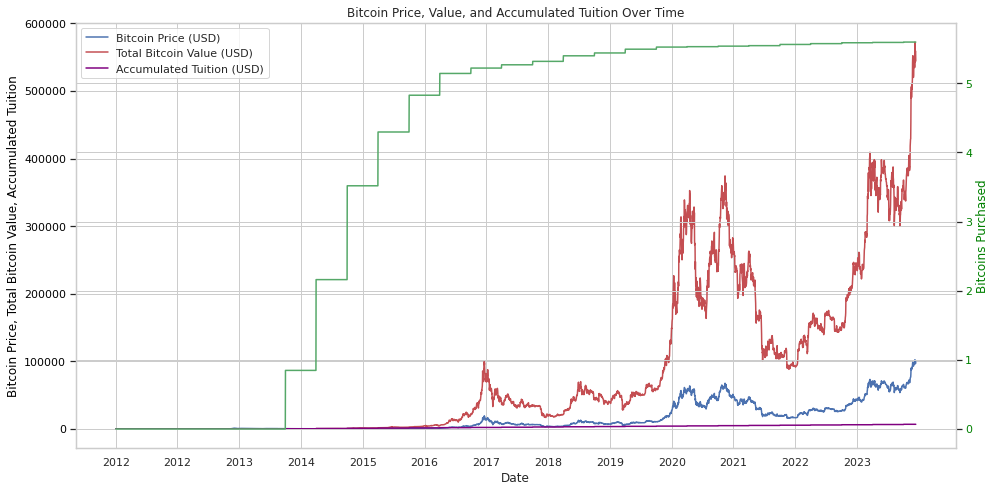

In [21]:

final_data = pd.read_csv('final_btc_tuition_data.csv')

# Ensure 'Date' is in datetime format
final_data['Date'] = pd.to_datetime(final_data['Date'])

# Filter the data to start just before the first Bitcoin purchase
start_date = final_data['Date'].iloc[0]  # Get the first date of purchase
filtered_data_for_plot = final_data[final_data['Date'] >= start_date]

# Set the plotting style
sns.set(style="whitegrid")

# Create a plot with one graph and dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))# Plot Bitcoin Price, Total Bitcoin Value, and Accumulated Tuition (in USD)
sns.lineplot(x='Date', y='Low', data=filtered_data_for_plot, ax=ax1, color='b', label='Bitcoin Price (USD)')
sns.lineplot(x='Date', y='Bitcoin Value', data=filtered_data_for_plot, ax=ax1, color='r', label='Total Bitcoin Value (USD)')
sns.lineplot(x='Date', y='Accumulated Tuition', data=filtered_data_for_plot, ax=ax1, color='purple', label='Accumulated Tuition (USD)')

# Set the first y-axis labels (Bitcoin-related values)
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price, Total Bitcoin Value, Accumulated Tuition', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Bitcoins Purchased
ax2 = ax1.twinx()

# Plot Bitcoins Purchased correctly on the second axis
sns.lineplot(x='Date', y='Bitcoins Purchased', data=filtered_data_for_plot, ax=ax2, color='g', label='Bitcoins Purchased')

# Set the second y-axis labels (Bitcoins)
ax2.set_ylabel('Bitcoins Purchased', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Set titles and labels
ax1.set_title('Bitcoin Price, Value, and Accumulated Tuition Over Time')

# Adjust the x-axis to show every year correctly
ax1.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as 'YYYY'

# Ensure the x-axis ticks correspond to actual data points (without overlap)
plt.xticks(filtered_data_for_plot['Date'][::365], rotation=45)  # Sample ticks per year

# Remove redundant legends from ax2
ax2.legend_.remove()

# Save the plot as a high-resolution image
plt.tight_layout()
plt.savefig('bitcoin_analysis_plot_final.png', dpi=300)

# Show the plot
plt.show()

## So finally we can see how our Life would look like if we hadn't done our PhD. We would own half a million USD in bitcoin just by investing our tuition money.